# MP2: Sampling and Interpolation

In this lab, you'll create sinusoids at a variety of sampling rates, both above and below Nyquist, and compare the resulting stem plots.  Then you'll downsample a sinusoid, and interpolate it back to the original sampling rate, using a variety of different interpolation kernels.

In order to make sure everything works, you might want to go to the command line, and run `pip install -r requirements.txt`.  This will install the modules that are used on the autograder, including numpy, h5py, and the gradescope utilities.  You can do that using the exclamation point notation in a Jupyter notebook block, as shown here:

In [1]:
!pip install -r requirements.txt

Then import the modules that you'll need for this MP:

In [1]:
import submitted
import importlib
import numpy as np
import matplotlib.pyplot as plt
import h5py

---------------------------------------------------------------------
## Part 1: Comparing sinusoids at different frequencies

In this first part of the MP, you will create a sinusoid, and sample it at different sampling rates.  The four parameters will be
* `frequency` $f=$ frequency of the sinusoid  (Hertz)
* `phasor` $z=re^j\phi=$ phasor encoding its amplitude and phase
* `duration` $d=$ duration (seconds)
* `samplerate` $F_s=$ sampling rate (samples/second)

The returned signal should be
$$x[n] = \Re\{ z e^{j2\pi nf/F_s}\}$$

In [2]:
import importlib
importlib.reload(submitted)
help(submitted.sinusoid)

Help on function sinusoid in module submitted:

sinusoid(phasor: complex, frequency: float, duration: float, samplerate: float)
    timeaxis, signal = sinusoid(phasor, frequency, duration, samplerate)
    Generate a sinusoid.

    phasor (complex scalar) - magnitude times e^{j phase}
    frequency (real scalar) - frequency of the sinusoid, in Hertz
    duration (real scalar) - duration, in seconds
    samplerate (real scalar) - sampling rate, in samples/second
    timeaxis (array) - sample times, from 0 to duration, including endpoints
    signal (array) - the generated sinusoid, length = int(duration*samplerate+1)



First, let's generate a sinusoid with plenty of samples, so we make sure it plots correctly.  We'll use `stem` to plot it, so we can see each sample.  

Text(0.5, 1.0, '4Hz cosine, sampled at 32 samples/second')

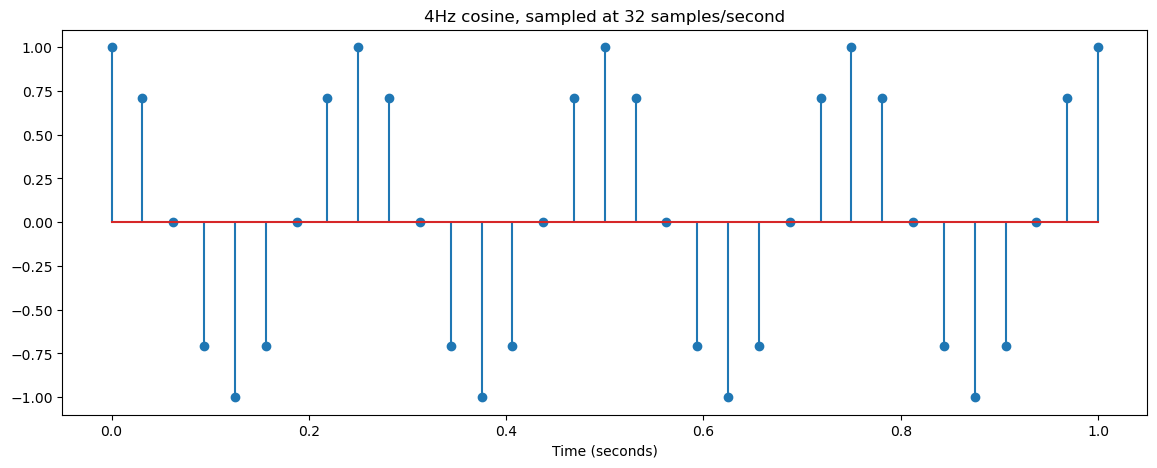

In [3]:
importlib.reload(submitted)
timeaxis, signal = submitted.sinusoid(1, 4, 1, 32)
plt.figure(figsize=(14, 5))
plt.stem(timeaxis, signal)
plt.xlabel('Time (seconds)')
plt.title('4Hz cosine, sampled at 32 samples/second')

Now let's see what happens when we gradually increase the frequency of the cosine.

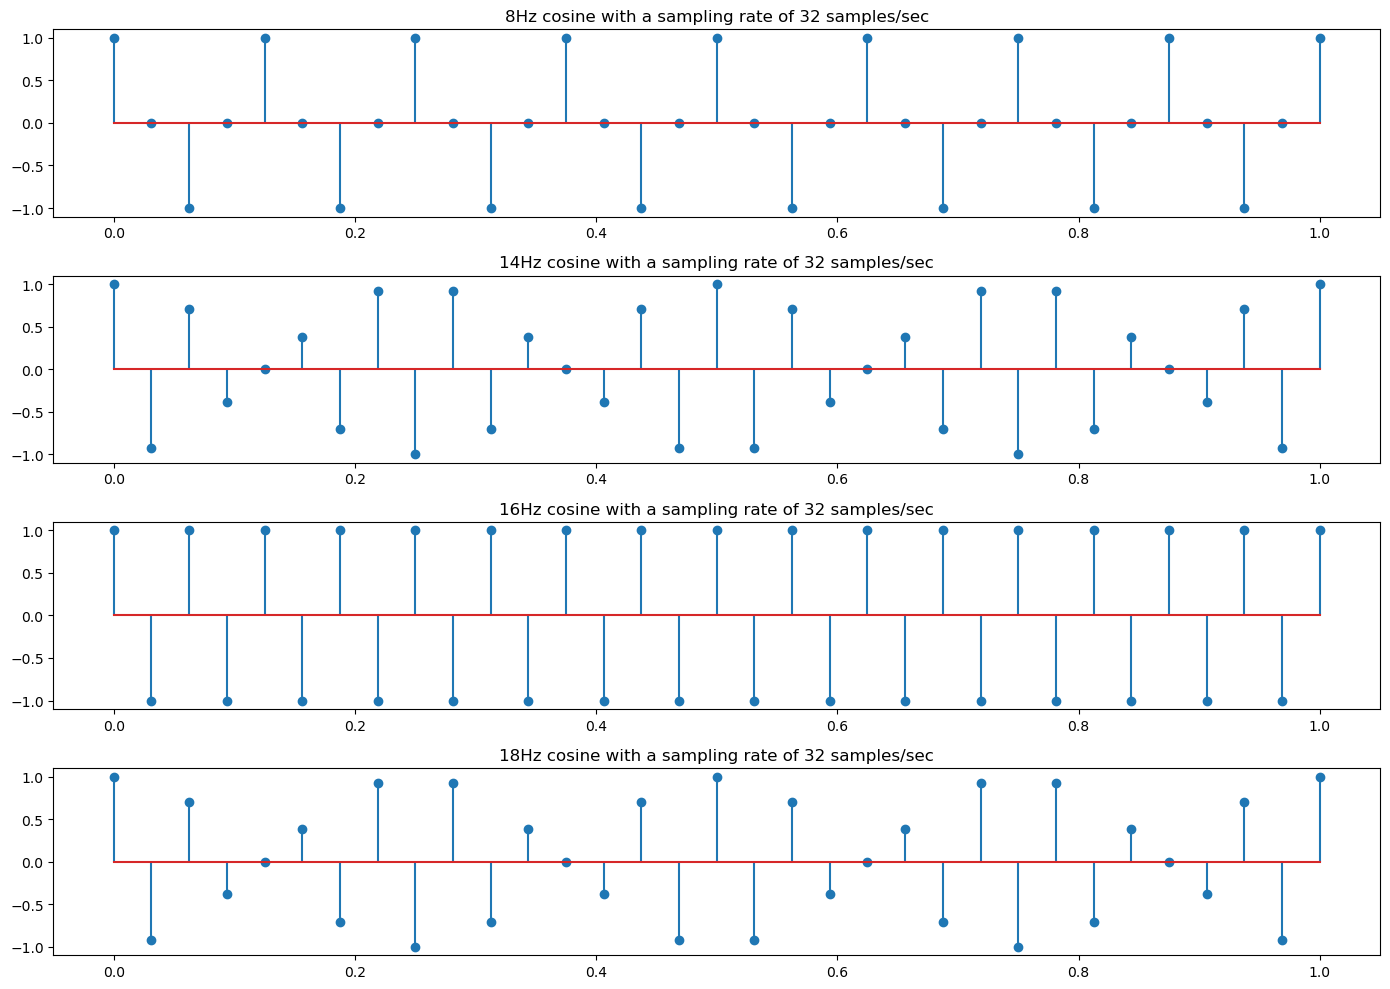

In [4]:
fig, ax = plt.subplots(4,1, figsize=(14,10))
frequencies = [8,14,16,18]
for k in range(len(frequencies)):
    timeaxis, signal = submitted.sinusoid(1, frequencies[k], 1, 32)
    ax[k].stem(timeaxis, signal)
    ax[k].set_title('%dHz cosine with a sampling rate of 32 samples/sec'%(frequencies[k]))
fig.tight_layout()

Notice that, as long as you have at least two samples per period ($F_s\ge 2f$), you can reconstruct the original cosine (e.g., there are four sign-reversals in one second, so you can see that it's a 4Hz sinusoid).  

But look at the 18Hz cosine!  In this case, $2f=36$, which is more than the sampling rate.  As a result, we have fewer than two samples per period.  Notice what happened as a result: the samples for the 18Hz cosine are **EXACTLY THE SAME SAMPLE VALUES** as the samples for the 14Hz cosine!

Speaking more generally, we can say that when $F_s < 2f$, the cosine gets "aliased" to a new "alias frequency," $f_a=F_s-f$.  That's because, for any integer $n$,

$$\cos\left(\frac{2\pi f n}{F_s}\right) = \cos\left(\frac{2\pi (F_s-f) n}{F_s}\right)$$

The highest frequency at which the cosine can be is called the "Nyquist rate", and it is 
$$F_N = \frac{1}{2}F_s$$

Let's look at a smaller number of samples per second, so that we can look more closely at what's going on.

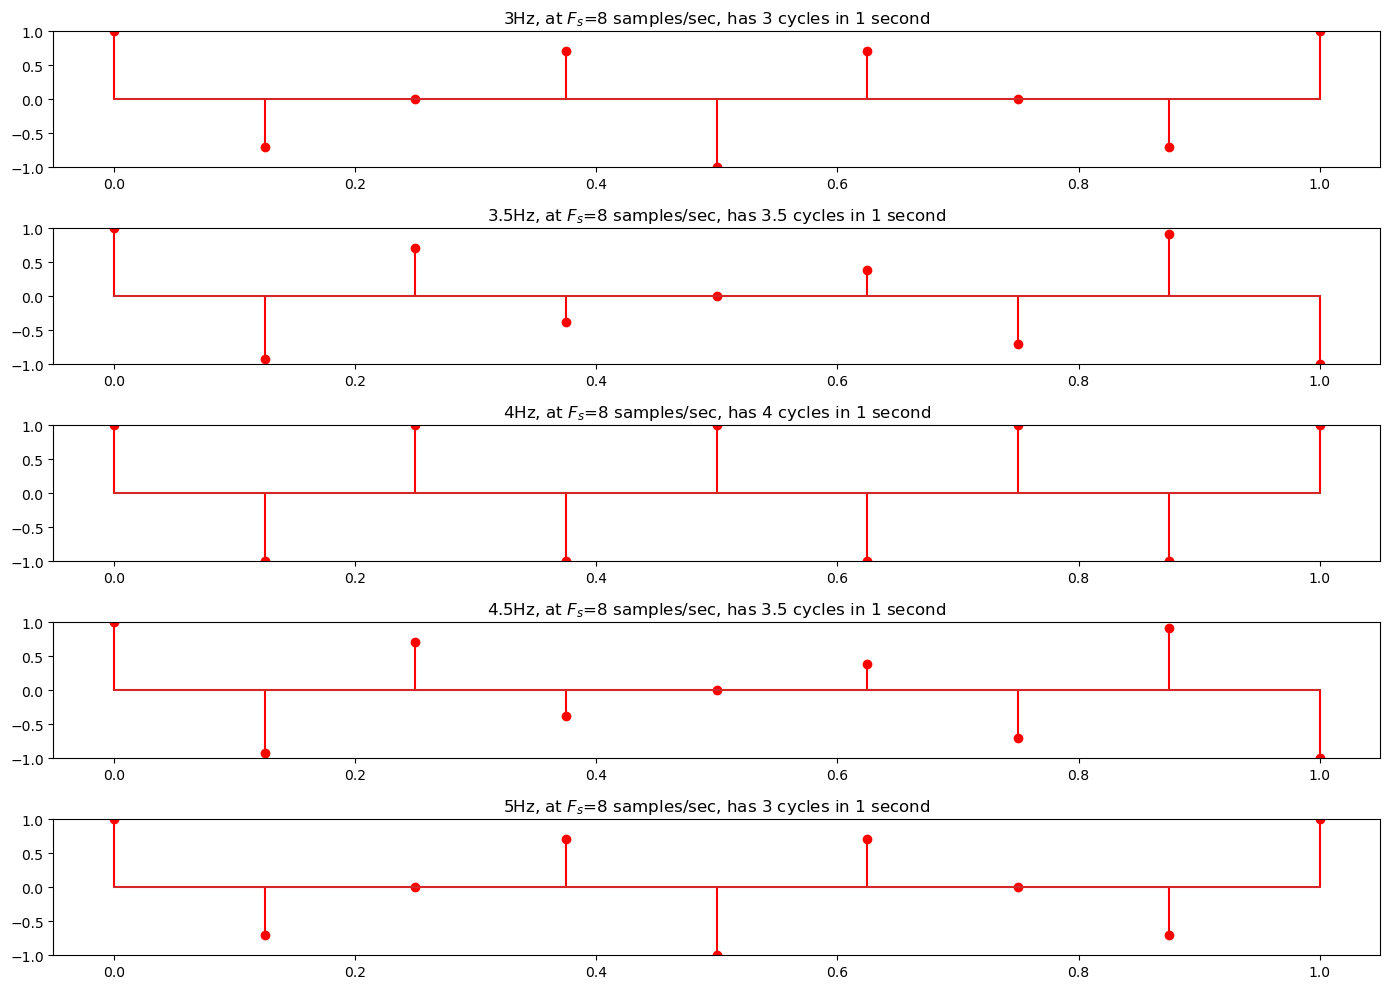

In [5]:
fig, ax = plt.subplots(5,1, figsize=(14,10))
frequencies = [3,3.5,4,4.5,5]
for k in range(5):
    timeaxis, signal = submitted.sinusoid(1, frequencies[k], 1, 8)
    ax[k].stem(timeaxis, signal, 'ro')
    timeaxis_high, signal_high = submitted.sinusoid(1, frequencies[k],1,100)
    #ax[k].plot(timeaxis_high, signal_high)
    alias = min(frequencies[k], 8-frequencies[k])
    ax[k].set_title('%gHz, at $F_s$=8 samples/sec, has %g cycles in 1 second'%(frequencies[k], alias))
    ax[k].set_ylim(-1,1)
fig.tight_layout()

Notice that, when $f > F_s/2$, it looks as though the sinusoid has a frequency of $F_s-f$.  This is called its "aliased frequency."  When the sampling rate gets even lower, aliasing can be even worse.  The aliased frequency in general is

$$f_a = \min\left(f \mbox{mod} F_s, (F_s-f)\mbox{mod} F_s\right)$$

where $\mbox{mod}$ means modulo (written in python as `f % Fs`).  Let's see some examples.

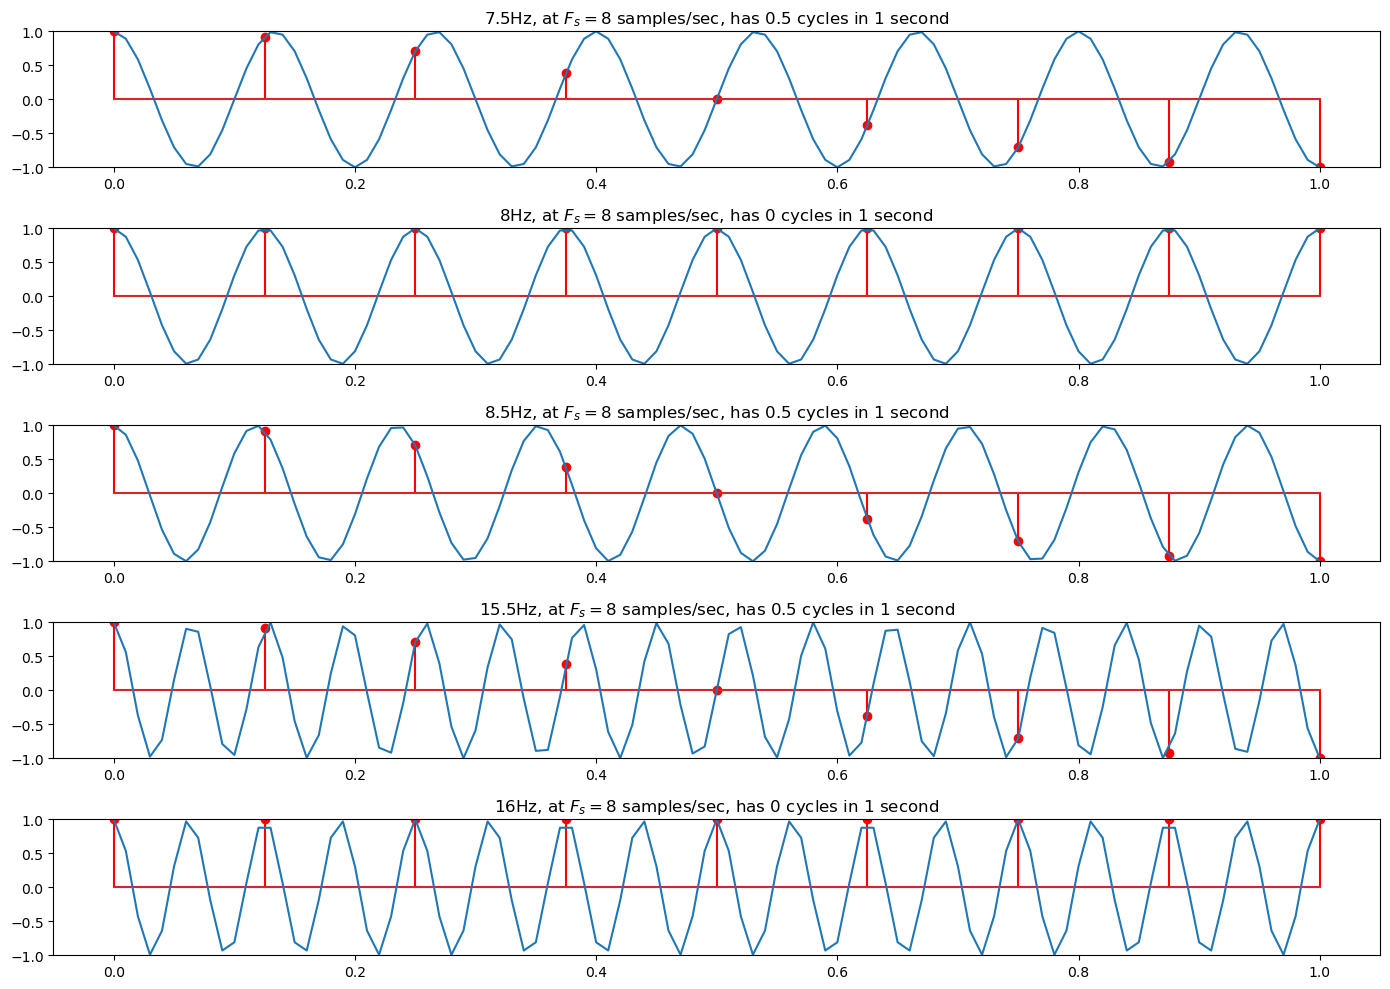

In [6]:
fig, ax = plt.subplots(5,1, figsize=(14,10))
frequencies = [7.5,8,8.5,15.5,16]
for k in range(5):
    timeaxis, signal = submitted.sinusoid(1, frequencies[k], 1, 8)
    ax[k].stem(timeaxis, signal, 'ro')
    timeaxis_high, signal_high = submitted.sinusoid(1, frequencies[k],1,100)
    ax[k].plot(timeaxis_high, signal_high)
    alias = min(frequencies[k] % 8, (8-frequencies[k]) % 8)
    ax[k].set_title('%gHz, at $F_s=8$ samples/sec, has %g cycles in 1 second'%(frequencies[k], alias))
    ax[k].set_ylim(-1,1)
fig.tight_layout()

Exactly the same thing happens to sine waves as to cosines, except that:

1. When $f=F_s/2$ exactly, the sine wave disappears.  
2. When $F_s/2 < f < F_s$, the sign of the sine reverses.  That's because
$$\sin\left(\frac{2\pi f n}{F_s}\right) = -\sin\left(\frac{2\pi (F_s-f) n}{F_s}\right)$$

In order to plot sine waves, we'll use a phasor of $-j=e^{-j\pi/2}$, to give it a phase of $-\pi/2$.

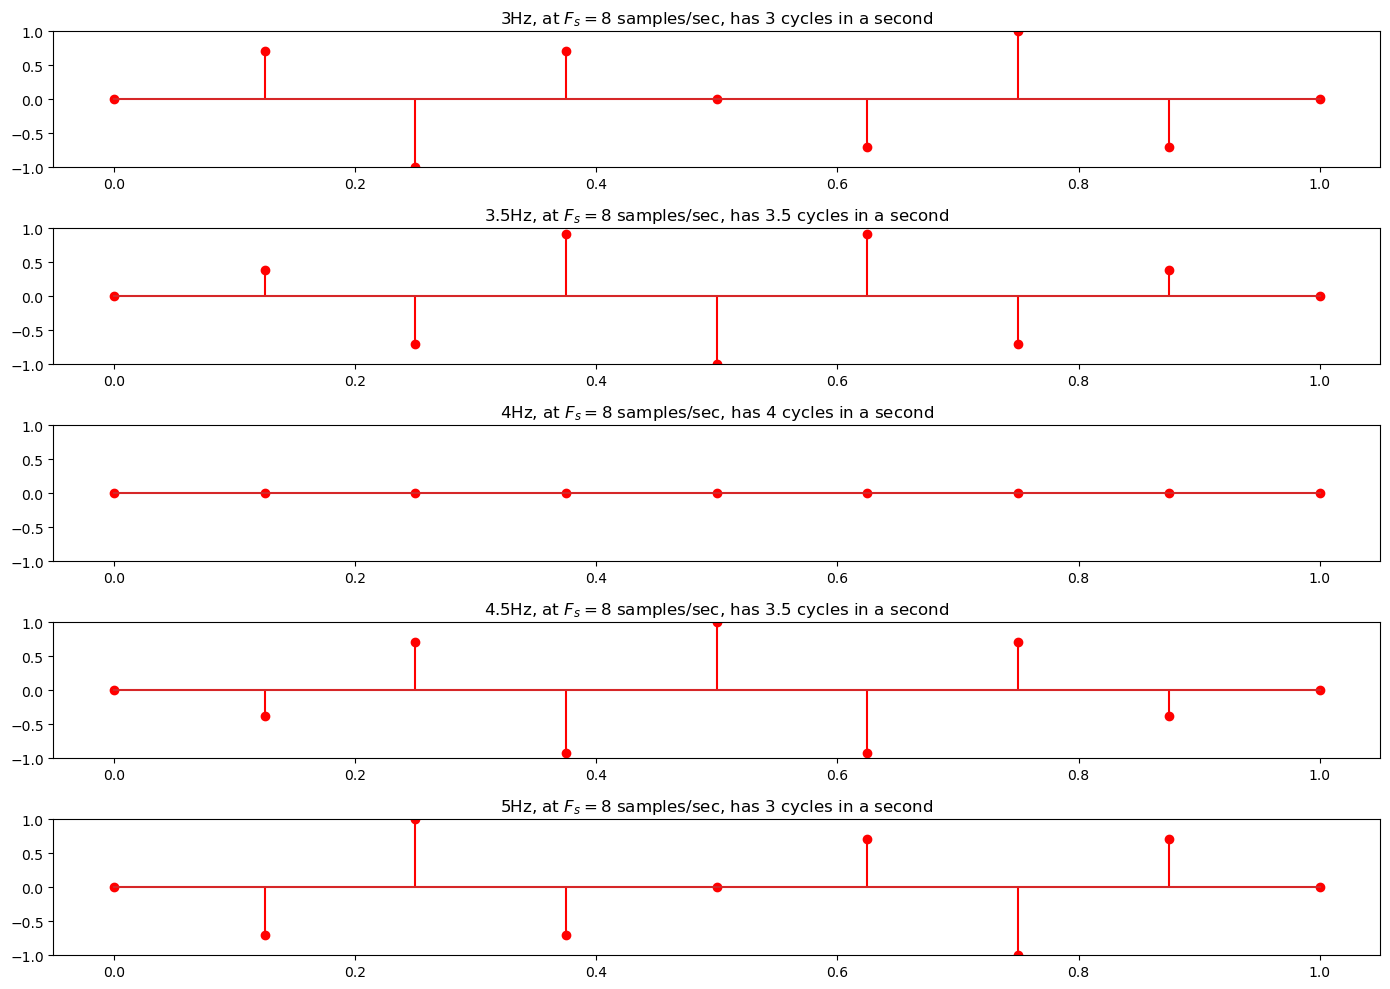

In [7]:
fig, ax = plt.subplots(5,1, figsize=(14,10))
frequencies = [3,3.5,4,4.5,5]
for k in range(5):
    timeaxis, signal = submitted.sinusoid(-1j, frequencies[k], 1, 8)
    ax[k].stem(timeaxis, signal, 'ro')
    alias = min(frequencies[k] % 8, (8-frequencies[k]) % 8)
    timeaxis_high, signal_high = submitted.sinusoid(-1j, frequencies[k],1,100)
    #ax[k].plot(timeaxis_high, signal_high)
    ax[k].set_title('%gHz, at $F_s=8$ samples/sec, has %g cycles in a second'%(frequencies[k], alias))
    ax[k].set_ylim(-1,1)
fig.tight_layout()

## Part 2: Computing the alias frequency and aliased phasor

These two equations:
$$\cos\left(\frac{2\pi f n}{F_s}\right) = \cos\left(\frac{2\pi (F_s-f) n}{F_s}\right)$$
$$\sin\left(\frac{2\pi f n}{F_s}\right) = -\sin\left(\frac{2\pi (F_s-f) n}{F_s}\right)$$

...can be combined to give this equation:
$$\Re\left\{z \exp\left(j\frac{2\pi f n}{F_s}\right)\right\}=\Re\left\{z^* \exp\left(j\frac{2\pi (F_s-f) n}{F_s}\right)\right\}$$

In other words,
* You can ignore any integer multiple of $F_s$.  For any integer $k$:

$$ze^{j2\pi \left(\frac{f+kF_s}{F_s}\right)n}=ze^{j2\pi \left(\frac{f}{F_s}\right)n}$$

* A negative-frequency phasor is the same thing as a positive frequency phasor with the opposite phase: 

$$ze^{-j2\pi \left(\frac{f}{F_s}\right)n}=z^*e^{j2\pi \left(\frac{f}{F_s}\right)n}$$


If you like, these things can be combined to give the following rules:

* If $\frac{f}{F_s}>\text{round}\left(\frac{f}{F_s}\right)$, then the aliased frequency and phasor are $f_a=f\mod F_s,z_a=z$.
* If $\frac{f}{F_s}<\text{round}\left(\frac{f}{F_s}\right)$, then the aliased frequency and phasor are $f_a=(F_s-f)\mod F_s,z_a=z^*$.

For example, let's look at the signal
$$x(t) = \cos\left(2\pi ft-\frac{\pi}{4}\right)$$

This is a cosine delayed by $\pi/4$ radians.  It's positive for about $3/8$ of a period, then negative for $1/2$ period, and so on.

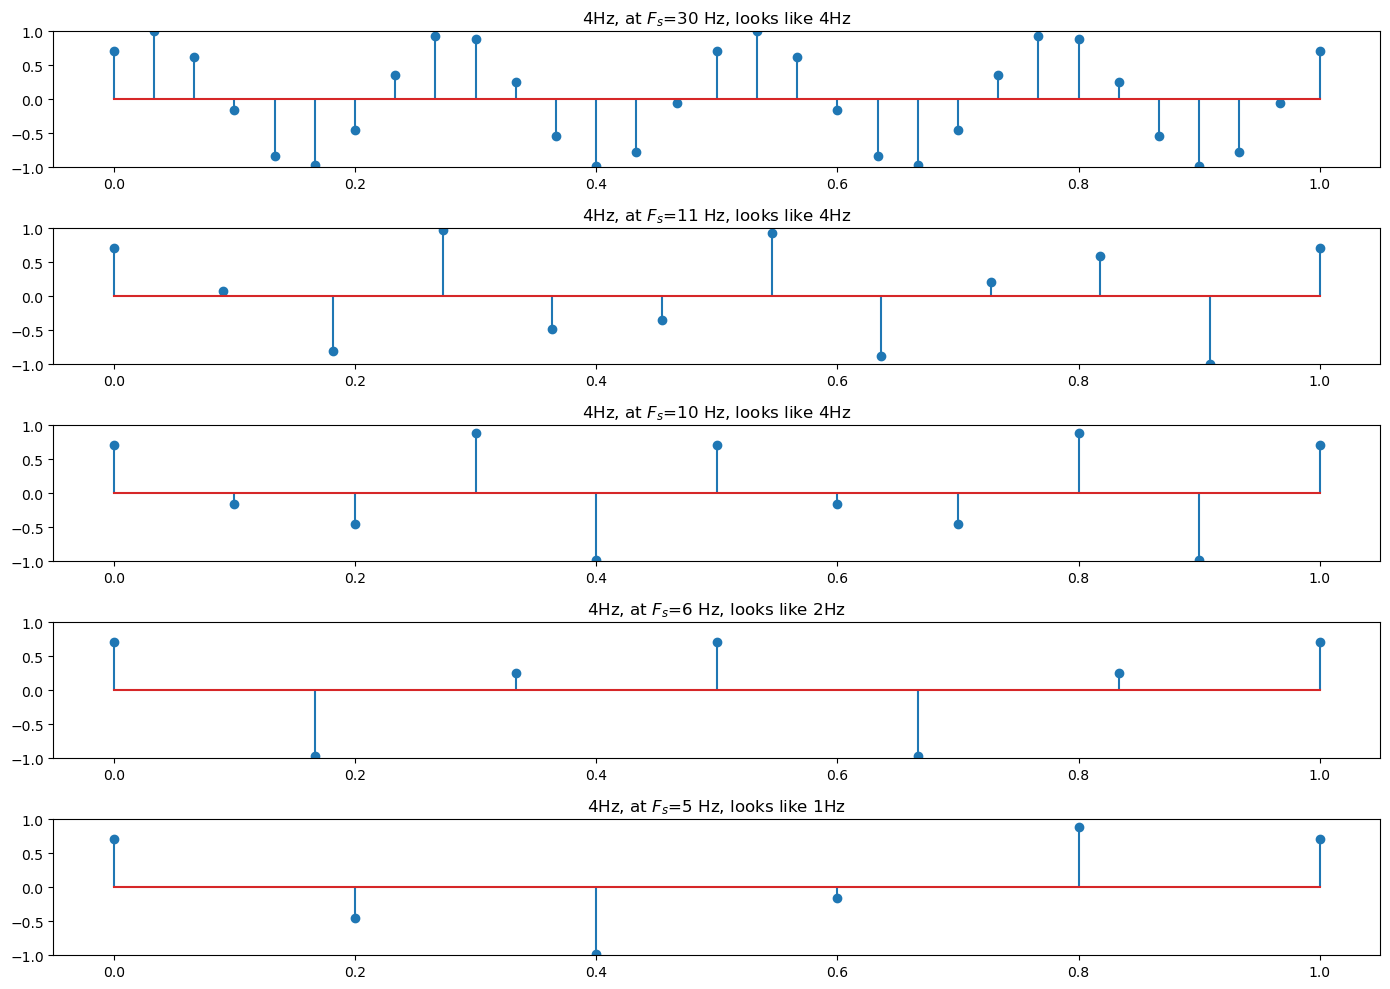

In [12]:
fig, ax = plt.subplots(5,1, figsize=(14,10))
samplerates = [30,11,10,6,5]
for k in range(5):
    phasor = np.exp(-1j*np.pi/4)
    timeaxis, signal = submitted.sinusoid(phasor, 4, 1, samplerates[k])
    ax[k].stem(timeaxis, signal)
    alias = min(4 % samplerates[k], (samplerates[k]-4) % samplerates[k])
    ax[k].set_title('4Hz, at $F_s$=%g Hz, looks like %gHz'%(samplerates[k], alias))
    ax[k].set_ylim(-1,1)
fig.tight_layout()

Sometimes it's useful to explicitly calculate the aliased frequency and aliased phasor (HINT: you probably want to use the `np.mod` method):

In [8]:
importlib.reload(submitted)
help(submitted.compute_aliasing)

Help on function compute_aliasing in module submitted:

compute_aliasing(frequencies, phasors, samplerates)
    aliased_freqs, aliased_phasors = compute_aliasing(frequencies, phasors, samplerates)
    Find the frequency and phasor of sinusoid aliases.  All arguments should have same length.

    frequencies (real array) - frequencies of the sinusoids, in Hertz
    phasors (complex array) - magnitudes times e^{j phases}
    samplerates (real array) - sampling rates, in samples/second
    aliased_freqs (real array)  - frequencies at which sinusoids seems to occur, in Hertz
    aliased_phasors (complex array) - phasors with which sinusoids seems to occur



In [9]:
importlib.reload(submitted)
samplerates = np.array([30,11,10,6,5])
freqs = np.repeat(4, 5)
phasors = np.repeat(np.exp(-1j*np.pi/4), 5)
aliased_freqs, aliased_phasors = submitted.compute_aliasing(freqs, phasors, samplerates)
print(aliased_freqs)
print(aliased_phasors)

RuntimeError: You need to write this part!

If we plot a sinusoid at the aliased frequency and aliased phasor, it should look exactly the same as the original sinusoid.

In [15]:
importlib.reload(submitted)
time1, original = submitted.sinusoid(phasors[-1],freqs[-1],2,samplerates[-1])
time2, alias = submitted.sinusoid(aliased_phasors[-1],aliased_freqs[-1],2,samplerates[-1])
time3, oops = submitted.sinusoid(aliased_phasors[0],aliased_freqs[-1],2,samplerates[-1])


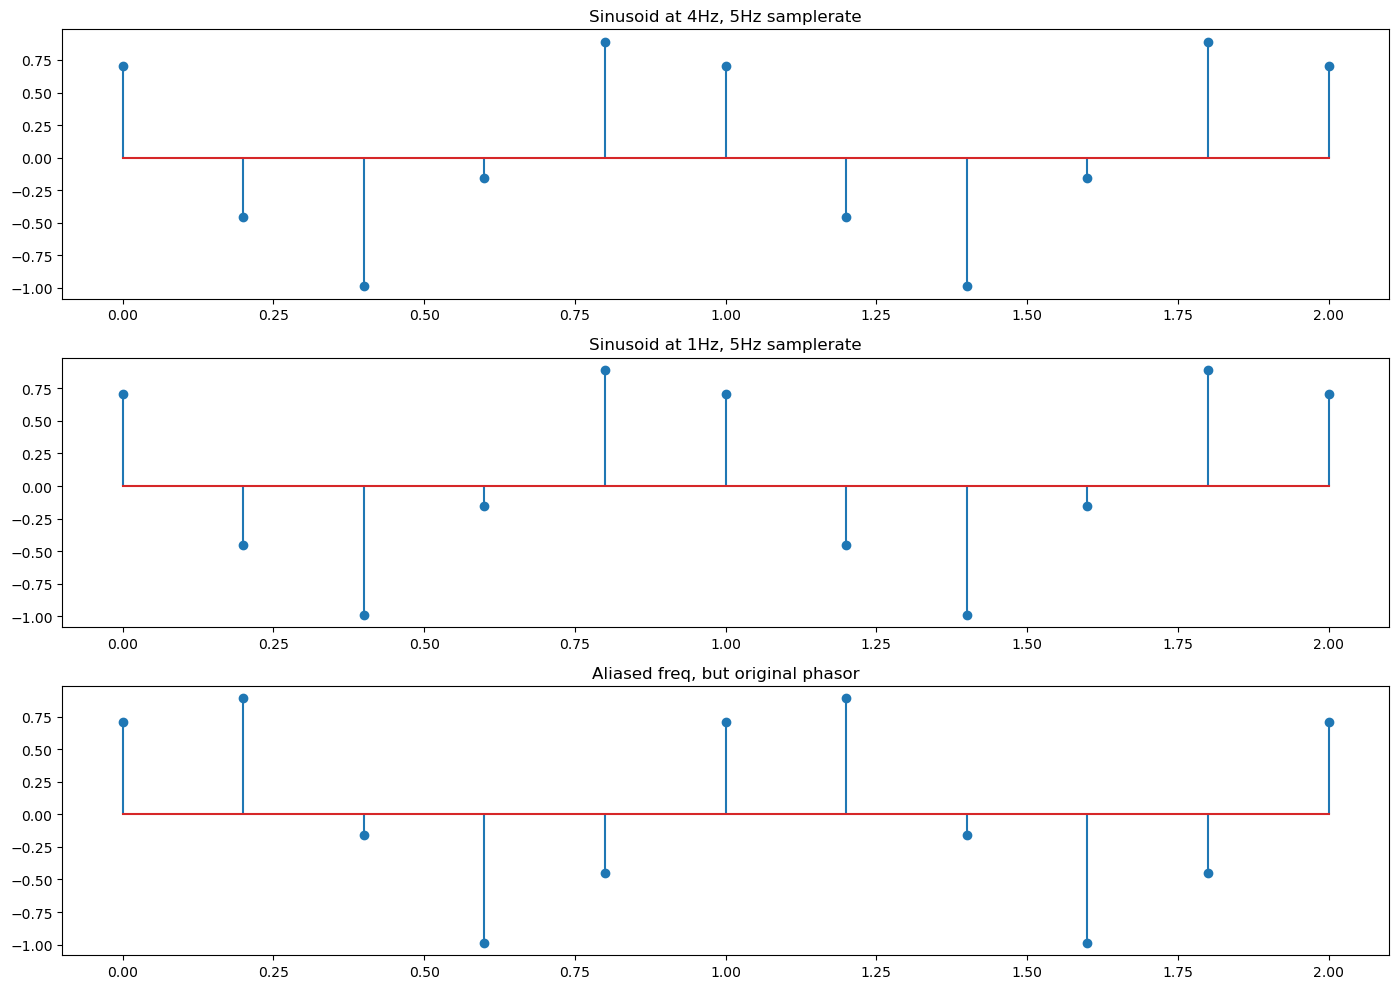

In [16]:
fig, ax = plt.subplots(3,1, figsize=(14,10))
ax[0].stem(time1, original)
ax[0].set_title('Sinusoid at %dHz, %dHz samplerate'%(freqs[-1],samplerates[-1]))
ax[1].stem(time2, alias)
ax[1].set_title('Sinusoid at %dHz, %dHz samplerate'%(aliased_freqs[-1],samplerates[-1]))
ax[2].stem(time3, oops)
ax[2].set_title('Aliased freq, but original phasor')
fig.tight_layout()

------------------------------------------------------------
## Part 3: Fourier analysis

Remember that, if you have a signal that's periodic  with a period $T_0$, then you can find its Fourier series coefficients using the Fourier analysis formula:
$$X_k = \frac{1}{T_0}\int_{0}^{T_0} x(t) e^{-j\frac{2\pi kt}{T_0}}dt$$

We can get a pretty good measurement of $X_k$ on a computer by setting the sampling rate high enough, replacing the integral by a sum, and multiplying the integrand by $F_s$ (to represent $dt=1/F_s$).  After simplifying a little, we get:
$$X_k = \frac{1}{N_0} \sum_{n=0}^{N_0-1} x[n]e^{-j\frac{2\pi kn}{N_0}}$$
where
$$N_0 = T_0F_s$$
During the rest of this MP, it will be useful to have a good Fourier analysis function, so let's write it.

In [17]:
importlib.reload(submitted)
help(submitted.fourier_analysis)

Help on function fourier_analysis in module submitted:

fourier_analysis(signal, number_of_coefficients)
    coefficients = fourier_analysis(signal, number_of_coefficients)
    Find the Fourier series coefficients using the discrete-time Fourier analysis formula.
    
    signal (array of length N_0) = one period of the signal
    number_of_coefficients (scalar) = number of coefficients to compute, starting with X_0
    coefficients (array of length=number_of_coefficients) = X_0 through X_{number_of_coefficients-1}



Remember that, if a signal is periodic with period $N_0$, then it's also periodic with any period that's a multiple of $N_0$.  We can use that fact to make the plot easier to read, e.g., by using four periods of a cosine as if they were just one period; that way the coefficient $X_1$ will be plotted as if it were $X_4$.  

Let's choose a cosine with a really long period, say, 50 samples, and then compute the Fourier series coefficients over a space of 200 samples.

In [18]:
n = np.arange(200)
signal = np.cos(2*np.pi*n/50)
k = np.arange(41)/4
coefficients = submitted.fourier_analysis(signal, 41)

Text(0.5, 0, '$k$')

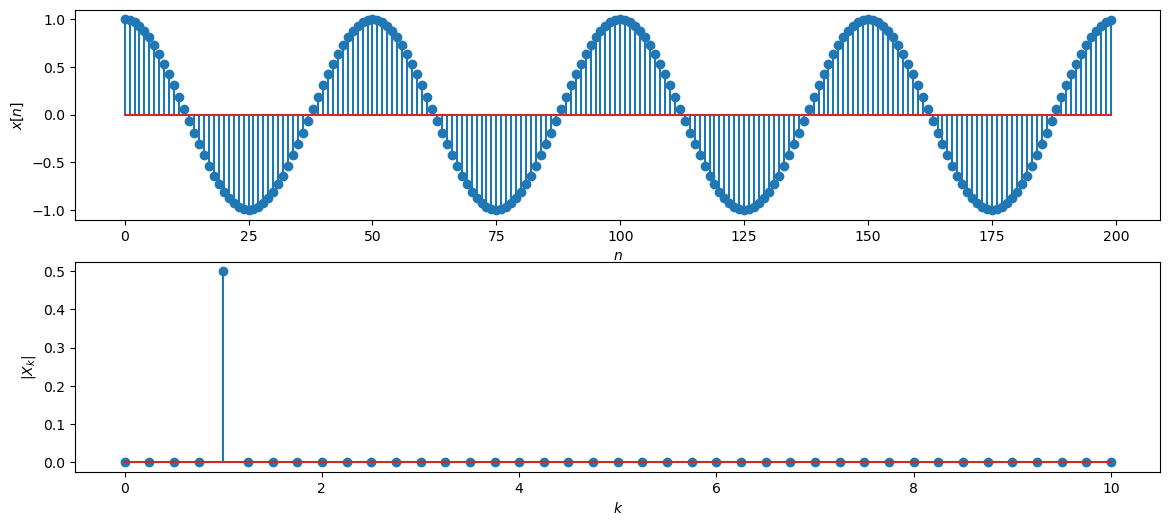

In [19]:
fig, ax = plt.subplots(2,1,figsize=(14,6))
ax[0].stem(n, signal)
ax[0].set_ylabel('$x[n]$')
ax[0].set_xlabel('$n$')
ax[1].stem(k, np.abs(coefficients))
ax[1].set_ylabel('$|X_k|$')
ax[1].set_xlabel('$k$')

-------------------------------------
## Part 4: Triangular kernel

Let's define the triangle function as follows:
$$h[n]=\begin{cases}1-\frac{|t|}{T}&-T+1\le n\le T-1\\0&\mbox{otherwise}\end{cases}$$

This function will be useful when we try to interpolate signals, in part 5.  Go ahead and write a function to compute it.   Notice that you only need to include the nonzero samples, not the zero-valued samples.

In [20]:
importlib.reload(submitted)
help(submitted.triangle)

Help on function triangle in module submitted:

triangle(T)
    timeaxis, h = triangle(T)
    Return a triangle function of length 2*T-1.
    
    T (scalar) - length of each side of the triangle, in samples
    timeaxis (array, length 2*T-1) - sample indices, from -(T-1) through (T-1)
    h (array, length 2*T-1) - the triangle function, 1 - abs(timeaxis)/T



In [21]:
importlib.reload(submitted)
t_timeaxis, triangle = submitted.triangle(25)

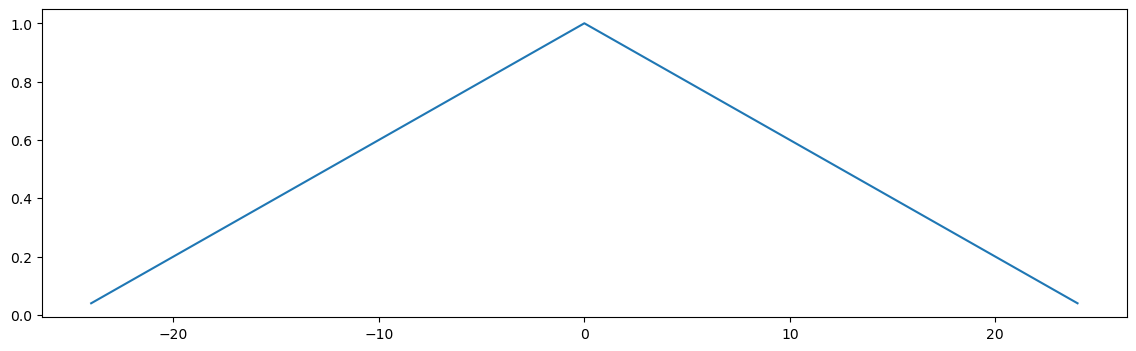

In [22]:
plt.figure(figsize=(14,4))
plt.plot(t_timeaxis, triangle)

-------------------------------------------------------------
## Part 5: Interpolation

We are now going to simulate a discrete-to-continuous time converter by downsampling our 50-sample cosine by a factor of 25, and then upsampling it by the same factor of 25.  The upsampling operation will use the same four types of interpolation that are used in typical D/C converters: rectangle, triangle, spline, and sinc.

First, let's downsample:

Text(0.5, 1.0, 'Cosine, sampled with only two samples per period')

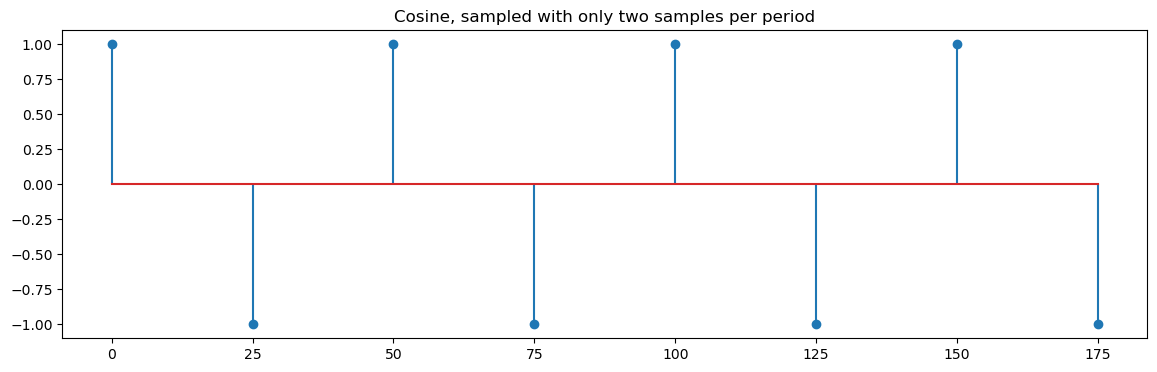

In [23]:
lowrate_signal = signal[::25]
lowrate_n = n[::25]
plt.figure(figsize=(14,4))
plt.stem(lowrate_n, lowrate_signal)
plt.title('Cosine, sampled with only two samples per period')

Now let's pretend we're interpolating it into continuous time.  The general formula for interpolation is

$$x(t) = \sum_{n=-\infty}^\infty x[n] h\left(t-nT\right)$$

where $T$ is the sampling period.  

In order to simulate D-to-C conversion, 
we will use $t$ to represent time in the highrate signal (e.g., $0\le t<200$) instead of time in the continuous-time signal.  We'll use $n$ to represent time in the lowrate signal (e.g., in the example, $0\le n< 8$), while $T$ is the ratio between the  two sampling rates (e.g., $T=25$).  

In [21]:
importlib.reload(submitted)
help(submitted.interpolate)

Help on function interpolate in module submitted:

interpolate(lowrate_signal, T, kernel_timeaxis, kernel)
    highrate_signal = interpolate(lowrate_signal, T, kernel_timeaxis, kernel)
    Use lowrate-to-highrate conversion to simulate discrete-to-continuous conversion.
    
    lowrate_signal (length-N array) - the lowrate signal
    T (scalar) - ratio of highrate/lowrate, i.e., number of output samples per input sample
    kernel_timeaxis (array) - sample times of the kernel, at the highrate
    kernel (array) - the interpolation kernel.  length(kernel)==length(kernel_timeaxis).
    highrate_signal (length-N*T array) - the highrate signal
    
    Note: in order to keep the output to only N*T samples, use modulo arithmetic for the 
    interpolation, e.g.,
    highrate_signal[np.mod(kernel_timeaxis+n*T, N*T)] += kernel * lowrate_signal[n]



Notice those last few lines from the docstring.  The triangle function has a length of $2T-1$.  The lowrate signal has a length of $N$.  If you put in a triangle function in place of every lowrate sample, you'd get a total length of $NT+(T-1)$, but that's not what we want -- what we want is a signal of length $NT$.  In order to make that happen, we'll use modulo indexing, i.e., the interpolation formula should be implemented as

`for n in range(N):`

$$x\left((t+nT) \mbox{mod} NT\right) += h(t) x[n]$$

You might find the function `np.mod` to be useful.

In [22]:
importlib.reload(submitted)
highrate_signal = submitted.interpolate(lowrate_signal, 25, t_timeaxis, triangle)

Text(0.5, 1.0, 'Highrate "Continuous Time" Signal using Triangle Interpolator')

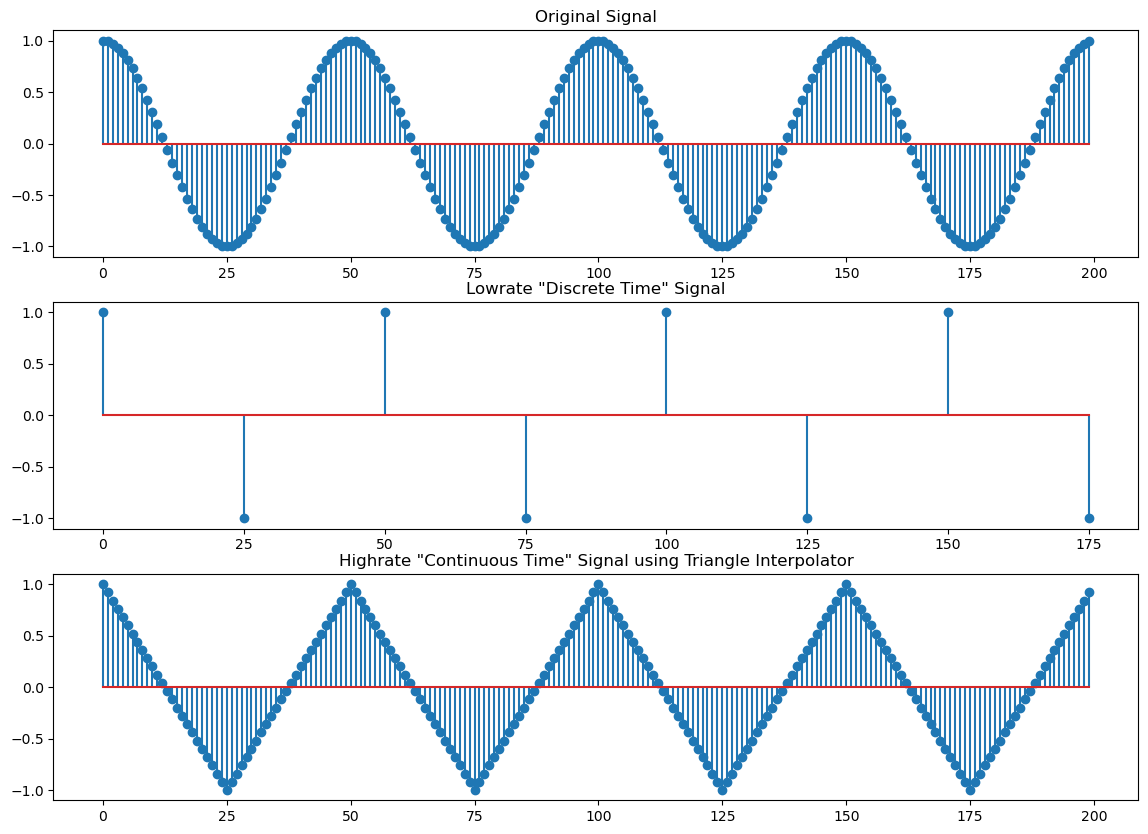

In [23]:
fig,ax = plt.subplots(3,1,figsize=(14,10))
ax[0].stem(n,signal)
ax[0].set_title('Original Signal')
ax[1].stem(lowrate_n, lowrate_signal)
ax[1].set_title('Lowrate "Discrete Time" Signal')
ax[2].stem(n, highrate_signal)
ax[2].set_title('Highrate "Continuous Time" Signal using Triangle Interpolator')

Well, it doesn't look very much like a  cosine!  In fact, it's just a linear interpolation between the lowrate samples.

In order to better understand what's going on, let's look at its spectrum.  In the following plot you should see that most of the spectral energy is at $X_1$, but there is significant nonzero energy also at $X_3$, $X_5$, and so on:

In [24]:
highrate_coefficients = submitted.fourier_analysis(highrate_signal, 41)

Text(0.5, 1.0, 'Fourier Series Coefficients of the Triangle-Interpolated Sinusoid')

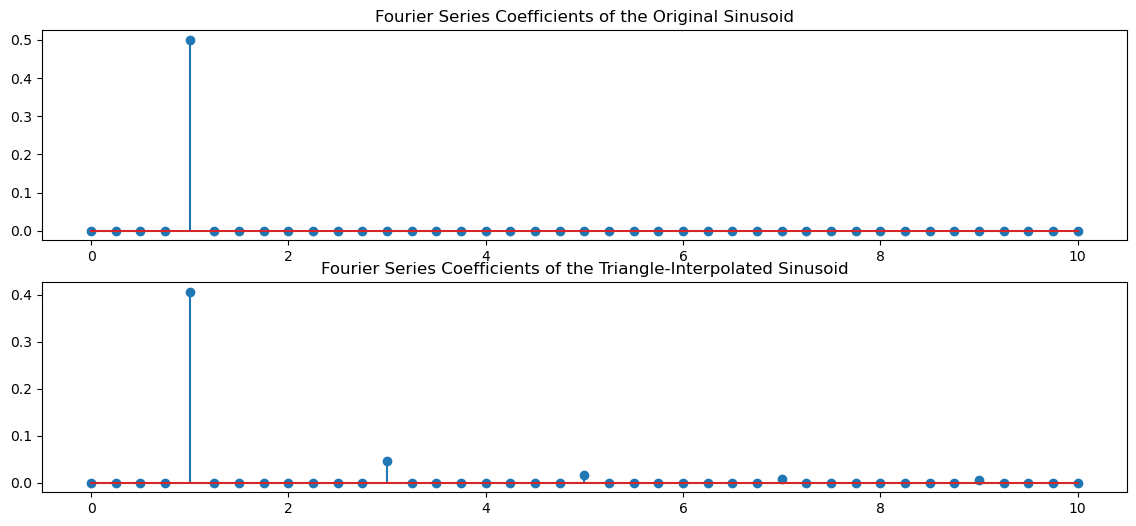

In [25]:
fig, ax = plt.subplots(2,1,figsize=(14,6))
ax[0].stem(k, np.abs(coefficients))
ax[0].set_title('Fourier Series Coefficients of the Original Sinusoid')
ax[1].stem(k, np.abs(highrate_coefficients))
ax[1].set_title('Fourier Series Coefficients of the Triangle-Interpolated Sinusoid')


-----------------------------------------------------------
## Part 6: Rectangle interpolation


Rectangle interpolation is much, much worse than triangle interpolation, but it's much easier to implement in hardware, so it's actually much more common in the real world.  Let's try it, and see how it turns out:

In [26]:
importlib.reload(submitted)
help(submitted.rectangle)

Help on function rectangle in module submitted:

rectangle(T)
    timeaxis, h = rectangle(T)
    Return a rectangle function of length T.
    
    T (scalar) - length, in samples
    timeaxis (length-T array) - sample indices, from 0 to T-1, corresponding to h
    h (length-T array) - the rectangle function



In [27]:
importlib.reload(submitted)
r_timeaxis, rectangle = submitted.rectangle(25)

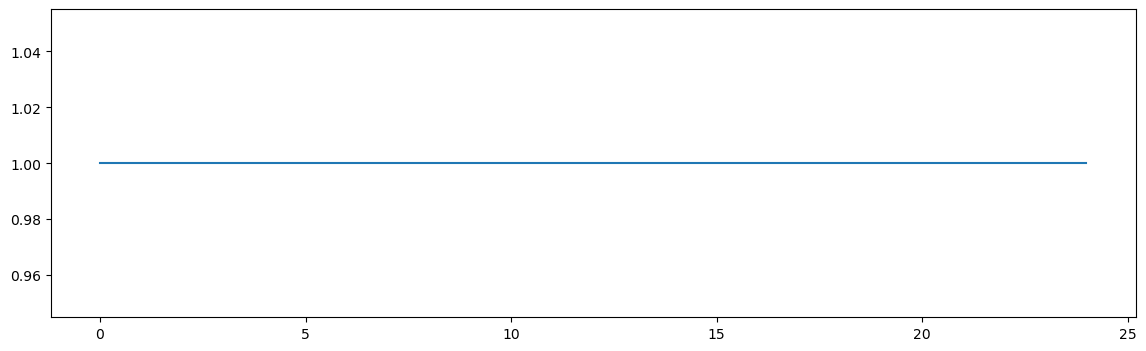

In [28]:
plt.figure(figsize=(14,4))
plt.plot(r_timeaxis, rectangle)

In [29]:
importlib.reload(submitted)
highrate_signal = submitted.interpolate(lowrate_signal, 25, r_timeaxis, rectangle)

Text(0.5, 1.0, 'Highrate "Continuous Time" Signal using Rectangle Interpolator')

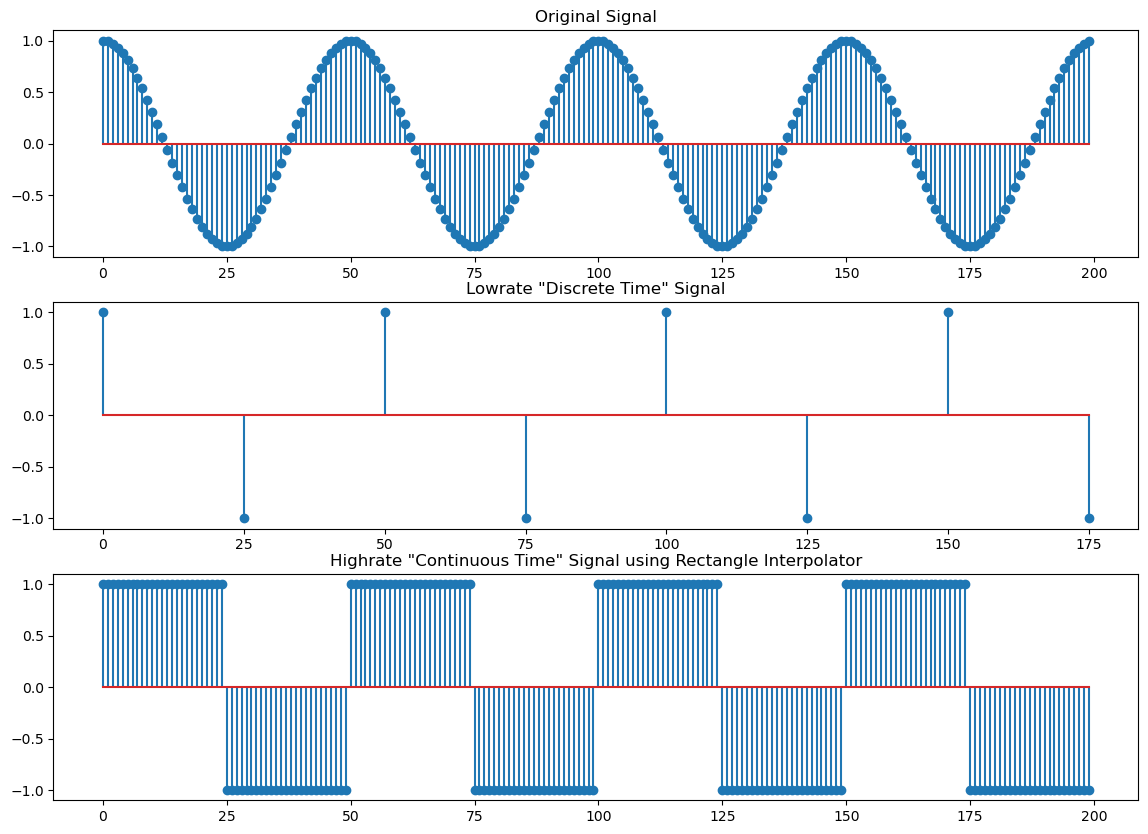

In [30]:
fig,ax = plt.subplots(3,1,figsize=(14,10))
ax[0].stem(n,signal)
ax[0].set_title('Original Signal')
ax[1].stem(lowrate_n, lowrate_signal)
ax[1].set_title('Lowrate "Discrete Time" Signal')
ax[2].stem(n, highrate_signal)
ax[2].set_title('Highrate "Continuous Time" Signal using Rectangle Interpolator')

In [31]:
highrate_coefficients = submitted.fourier_analysis(highrate_signal, 41)

Text(0.5, 1.0, 'Fourier Series Coefficients of the Rectangle-Interpolated Sinusoid')

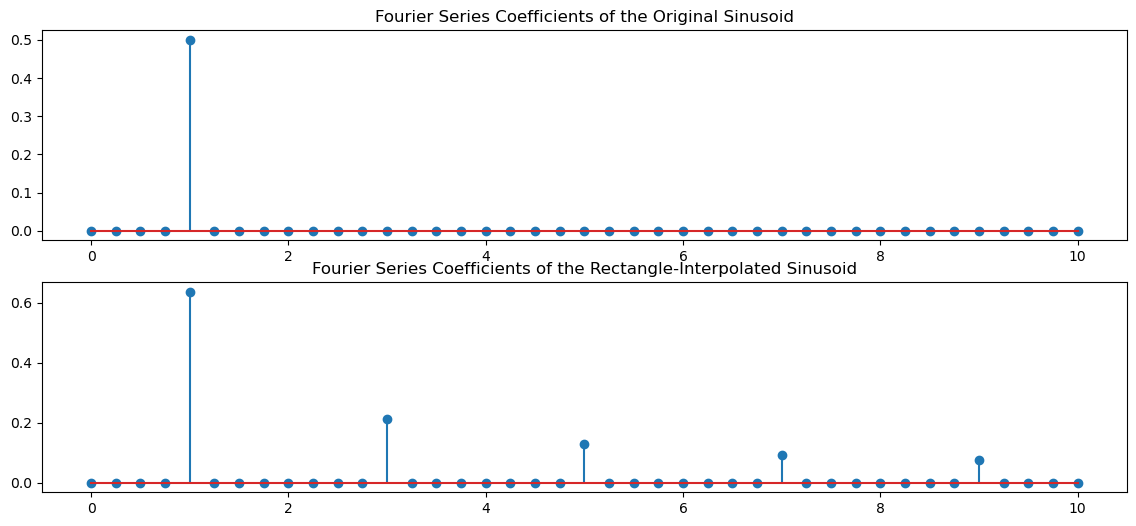

In [32]:
fig, ax = plt.subplots(2,1,figsize=(14,6))
ax[0].stem(k, np.abs(coefficients))
ax[0].set_title('Fourier Series Coefficients of the Original Sinusoid')
ax[1].stem(k, np.abs(highrate_coefficients))
ax[1].set_title('Fourier Series Coefficients of the Rectangle-Interpolated Sinusoid')


-----------------------------------------------------------------------------
## Part 7: Spline interpolation

One way of thinking about the superiority of triangle interpolation over rectangle interpolation is to say that the triangle-interpolated $x(t)$ is continuous, while the rectangle-interpolated $x(t)$ is not continuous.

We can make an even better interpolation if we try to make one that is continuous, and that has continuous first derivatives.

Remember that
$$x(t) = \sum x[n] h(t-nT)$$

* We want the kernel to be $h(0)=1$ at its center, and 
* $h(nT)=0$ at every other multiple of $T$. Taken together, these two constraints mean that $x(nT) = x[n]$ for every $n$.
* We want $h(t)$ to be a continuous function of time, as in the triangle function,
* We also want $h'(t)=\frac{dh}{dt}$ to be a continuous function of time, to make it even better than the triangle function.

All of those constraints can be satisfied by using a cubic spline interpolation kernel.  For example, the following cubic spline function satisfies these properties:

$$h(t) = \begin{cases}
1-\frac{3}{2}\left(\frac{|t|}{T}\right)^2+\frac{1}{2}\left(\frac{|t|}{T}\right)^3 & |t|\le T\\
-\frac{3}{2}\left(\frac{|t|-2T}{T}\right)^2\left(\frac{|t|-T}{T}\right)&T\le |t|\le 2T\\
0 &\mbox{otherwise}\end{cases}$$

In [33]:
importlib.reload(submitted)
help(submitted.spline)

Help on function spline in module submitted:

spline(T)
    timeaxis, h = spline(T)
    Return a continuous spline interpolator with continuous first deriviative.
    
    T (scalar) - the upsampling factor
    timeaxis (array, length 4*T-1) - sample indices, from -(2*T-1) through (2*T-1)
    h (array, length 4*T-1) - the cubic spline interpolation kernel



In [34]:
importlib.reload(submitted)
s_timeaxis, spline = submitted.spline(25)

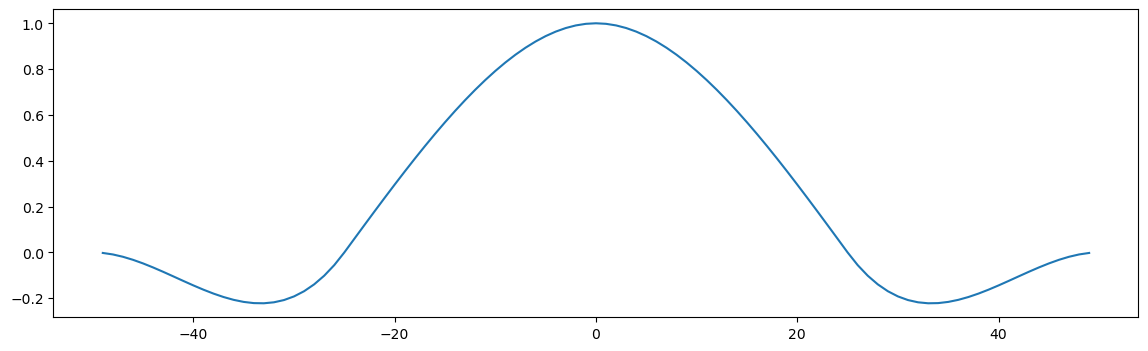

In [35]:
plt.figure(figsize=(14,4))
plt.plot(s_timeaxis, spline)

In [36]:
importlib.reload(submitted)
highrate_signal = submitted.interpolate(lowrate_signal, 25, s_timeaxis, spline)

Text(0.5, 1.0, 'Highrate "Continuous Time" Signal using Spline Interpolator')

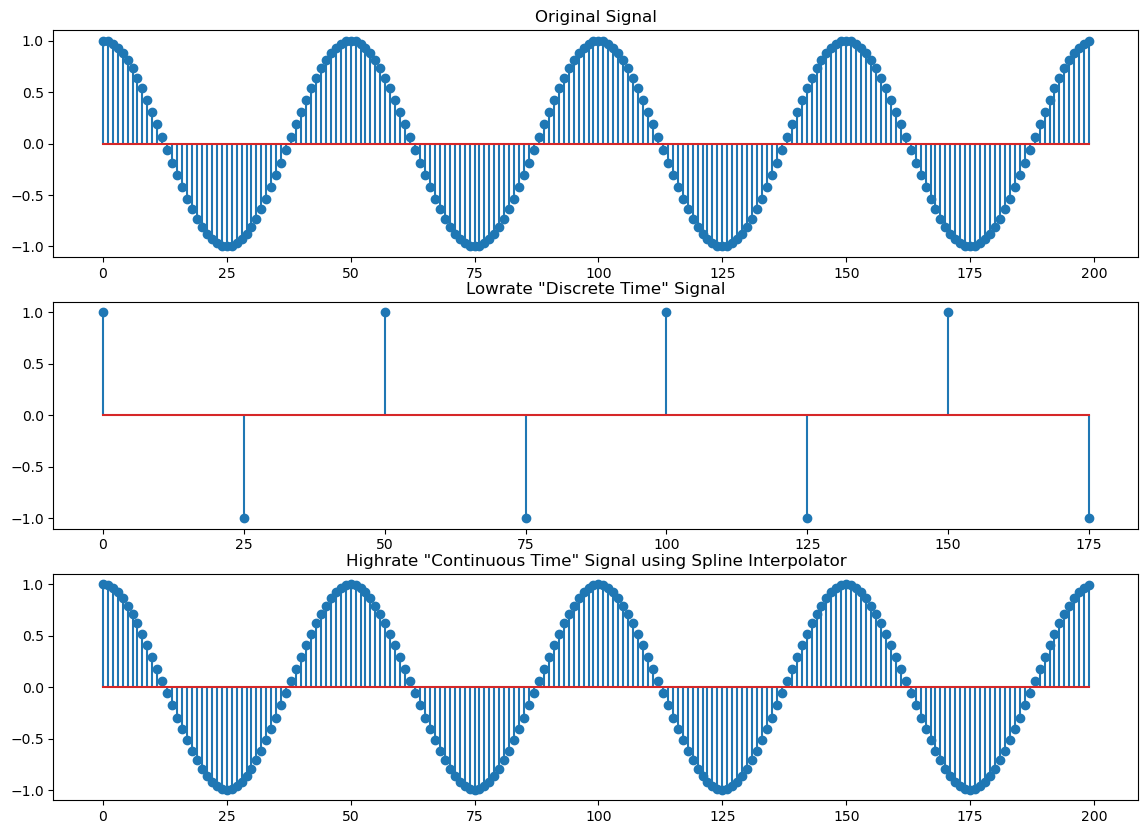

In [37]:
fig,ax = plt.subplots(3,1,figsize=(14,10))
ax[0].stem(n,signal)
ax[0].set_title('Original Signal')
ax[1].stem(lowrate_n, lowrate_signal)
ax[1].set_title('Lowrate "Discrete Time" Signal')
ax[2].stem(n, highrate_signal)
ax[2].set_title('Highrate "Continuous Time" Signal using Spline Interpolator')

In [38]:
highrate_coefficients = submitted.fourier_analysis(highrate_signal, 41)

Text(0.5, 1.0, 'Fourier Series Coefficients of the Spline-Interpolated Sinusoid')

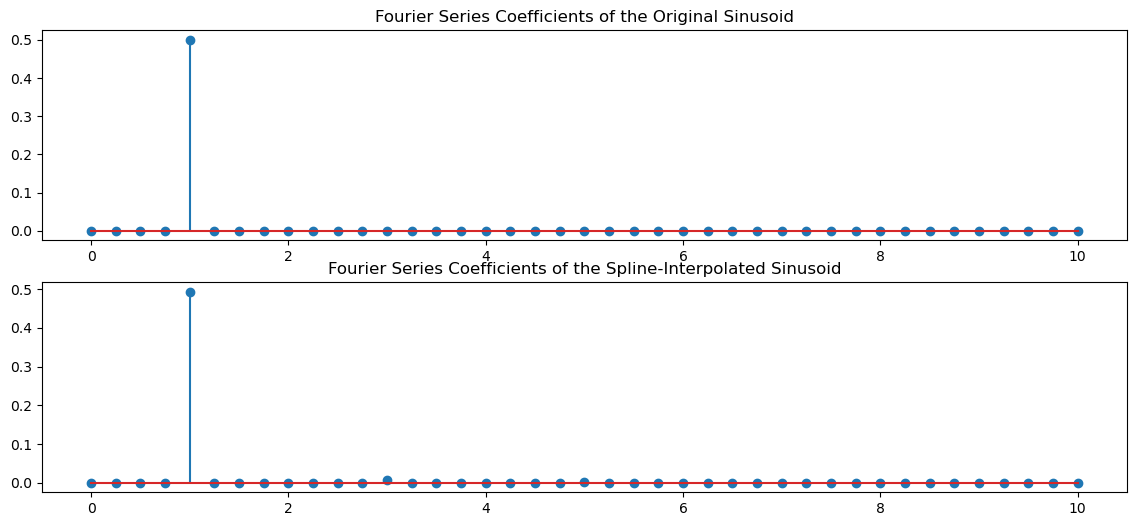

In [39]:
fig, ax = plt.subplots(2,1,figsize=(14,6))
ax[0].stem(k, np.abs(coefficients))
ax[0].set_title('Fourier Series Coefficients of the Original Sinusoid')
ax[1].stem(k, np.abs(highrate_coefficients))
ax[1].set_title('Fourier Series Coefficients of the Spline-Interpolated Sinusoid')


-----------------------------------------------------------------------------
## Part 8: Sinc interpolation

The spline-interpolated sinusoid looks a **whole** lot better than the triangle-interpolated sinusoid, doesn't it?  The Fourier series coefficients $X_3$ and $X_5$ are almost zero, but not quite -- it's hard to see in the plot above, but they do  include some energy.  Such energy may not be visible in an image, but human ears can sometimes hear it.

One might ask, is there any interpolation kernel for which **all** the derivatives are continuous?  In other words, not just $h'(t)=\frac{dh}{dt}$, but also $h''(t)=\frac{d^2h}{dt^2}$ is continuous, and so is $h'''(t)=\frac{d^3h}{dt^3}$, and so on?  The answer is yes.  The kernel with all derivatives continuous is called the sinc function, defined as:

$$h(t)=\begin{cases}
1 & t=0\\
\frac{\sin(\pi t/T)}{(\pi t/T)} & \mbox{otherwise}
\end{cases}$$

This is actually an infinite-length interpolation kernel, which is kind of inconvenient!  In order to actually use the sinc interpolator in practice, we need to truncate it after some fixed duration, as described in the  docstring:

In [40]:
importlib.reload(submitted)
help(submitted.sinc)

Help on function sinc in module submitted:

sinc(T, D)
    timeaxis, h = sinc(T, D)
    Return D samples from the center of h(t)=sin(pi*t/T) / (pi*t/T).
    
    T (scalar) - the upsampling factor
    D (scalar) - the duration of the returned kernel; always an odd number.
    timeaxis (array, length D) - sample indices, from -(D-1)/2 through (D-1)/2
    h (array, length 4*T-1) - the sinc interpolation kernel



In [41]:
importlib.reload(submitted)
sinc_timeaxis, sinc = submitted.sinc(25,199)

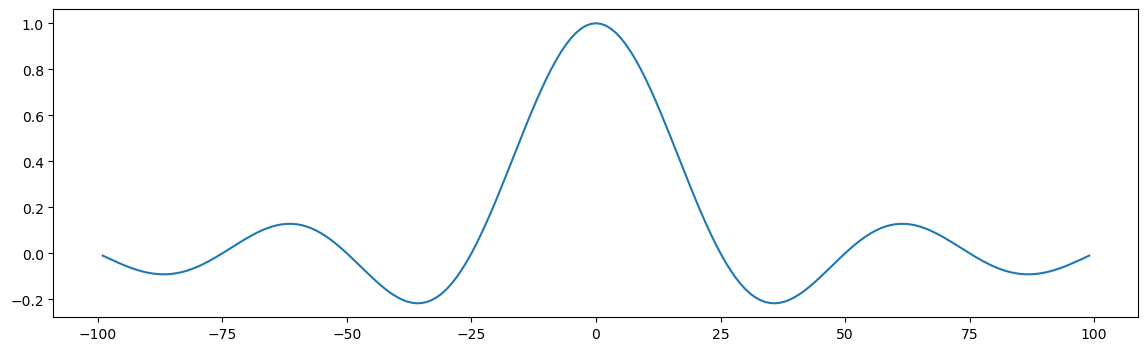

In [42]:
plt.figure(figsize=(14,4))
plt.plot(sinc_timeaxis, sinc)

In [43]:
importlib.reload(submitted)
highrate_signal = submitted.interpolate(lowrate_signal, 25, sinc_timeaxis, sinc)

Text(0.5, 1.0, 'Highrate "Continuous Time" Signal using Sinc Interpolator')

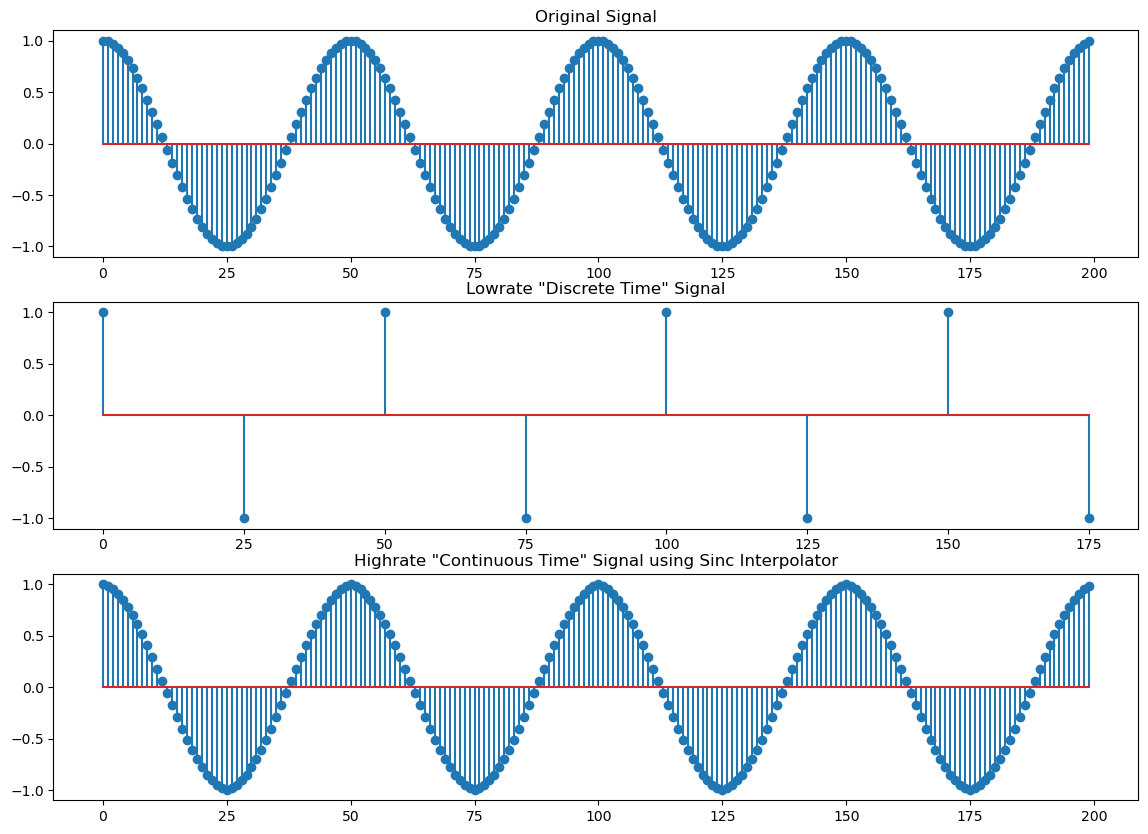

In [44]:
fig,ax = plt.subplots(3,1,figsize=(14,10))
ax[0].stem(n,signal)
ax[0].set_title('Original Signal')
ax[1].stem(lowrate_n, lowrate_signal)
ax[1].set_title('Lowrate "Discrete Time" Signal')
ax[2].stem(n, highrate_signal)
ax[2].set_title('Highrate "Continuous Time" Signal using Sinc Interpolator')

In [45]:
highrate_coefficients = submitted.fourier_analysis(highrate_signal, 41)

Text(0.5, 1.0, 'Fourier Series Coefficients of the Spline-Interpolated Sinusoid')

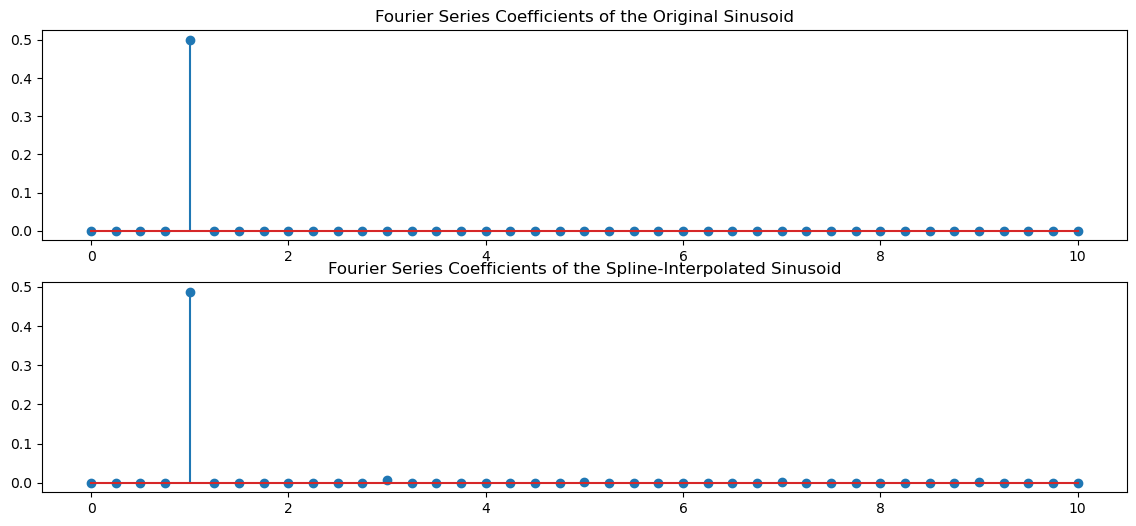

In [46]:
fig, ax = plt.subplots(2,1,figsize=(14,6))
ax[0].stem(k, np.abs(coefficients))
ax[0].set_title('Fourier Series Coefficients of the Original Sinusoid')
ax[1].stem(k, np.abs(highrate_coefficients))
ax[1].set_title('Fourier Series Coefficients of the Spline-Interpolated Sinusoid')


-----------------------------------------------------
## Part 8: Debugging using solutions.hdf5

If you reached this point in the notebook, then probably your code is working well, but before you run the autograder on  the  server, you should first run it on your own machine.

You can do that by going to a  terminal, and running the  following command line:

    python grade.py
    


In order to help you debug, you have the file `solutions.hdf5`.  You can use it to debug like this:

In [47]:
import h5py
with h5py.File('solutions.hdf5','r') as f:
    print(list(f.keys()))

['T', 'aliased_freqs', 'aliased_phasors', 'coefficients', 'duration', 'frequencies', 'frequency', 'highrate_signal', 'lowrate_signal', 'number_of_coefficients', 'phasor', 'phasors', 'r_timeaxis', 'rectangle', 's_timeaxis', 'samplerate', 'samplerates', 'signal', 'sinc', 'sinc_timeaxis', 'spline', 't_timeaxis', 'timeaxis', 'triangle']


As  you can see, this file contains a lot of objects, created during a sample run of the solution code with random parameters.  Let's plot the signal that it was expecting, the signal we created, and the difference between the two:

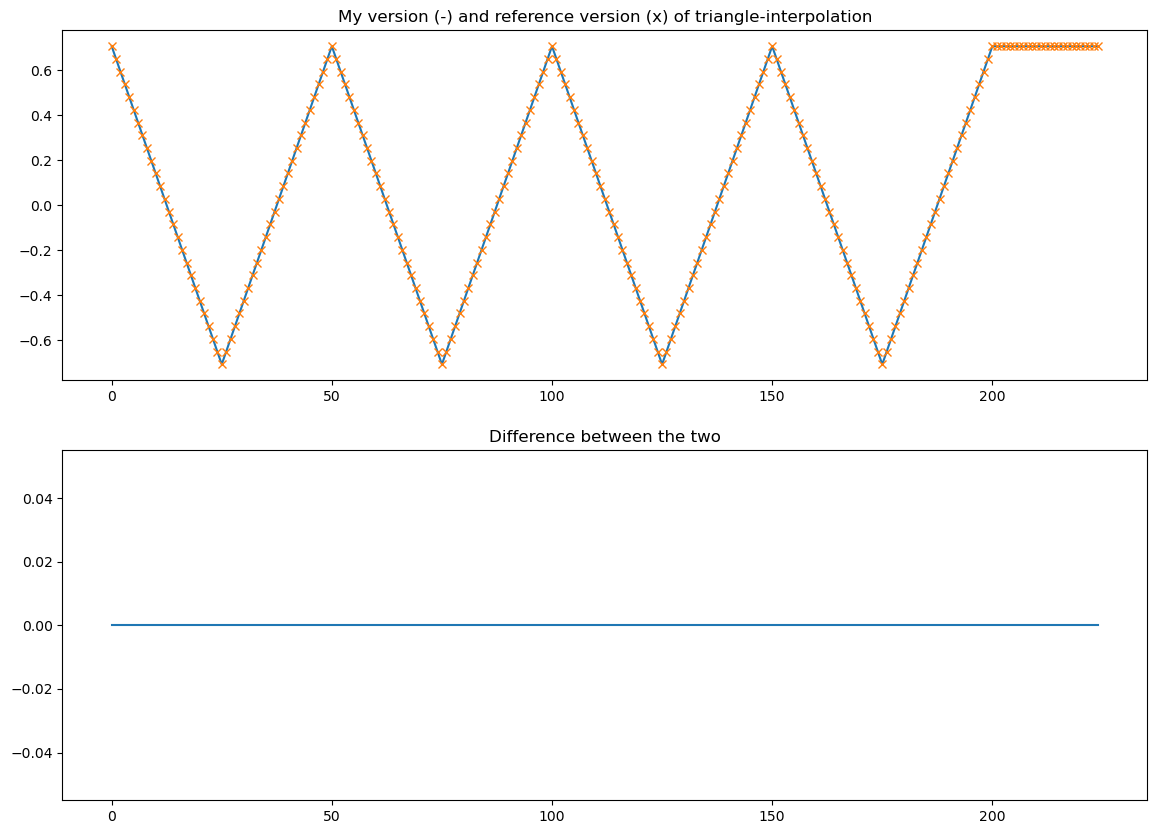

In [54]:
importlib.reload(submitted)
with h5py.File('solutions.hdf5','r')  as f:
    highrate_signal=submitted.interpolate(f['lowrate_signal'],f['T'][0], f['t_timeaxis'], f['triangle'])
    NT = len(highrate_signal)
    fig, ax = plt.subplots(2,1,figsize=(14,10))
    ax[0].plot(np.arange(NT),highrate_signal,'-',np.arange(NT),f['highrate_signal'][:],'x')
    ax[0].set_title('My version (-) and reference version (x) of triangle-interpolation')
    ax[1].plot(np.arange(NT),highrate_signal-f['highrate_signal'])
    ax[1].set_title('Difference between the two')

In [55]:
importlib.reload(submitted)
with h5py.File('solutions.hdf5','r')  as f:
    highrate_signal=submitted.interpolate(f['lowrate_signal'],f['T'][0], f['t_timeaxis'], f['triangle'])
    NT = len(highrate_signal)
    print(NT, len(f['lowrate_signal']), f['T'][0], len(f['t_timeaxis']), len(f['triangle']))
    print(f['t_timeaxis'][:])

225 9 25 49 49
[-24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7
  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11
  12  13  14  15  16  17  18  19  20  21  22  23  24]


If the lower plot has any nonzero values, those nonzero values are places where your solution differs from the reference solution.  If they differ by more than 0.01, then your solution will probably be marked incorrect, so you should figure out why those things have happened.

---------------------
## Extra Credit

You can earn up to 10%  extra credit on this MP by finishing the file called `extra.py`, and submitting it to the autograder.

This file has just one function, called `extra.rate_conversion`, with the following signature:

In [56]:
import extra
help(extra.rate_conversion)

Help on function rate_conversion in module extra:

rate_conversion(highrate_signal, highrate, lowrate)
    lowrate_signal, coefficients = rate_conversion(highrate_signal, highrate, lowrate)
    
    highrate_signal (real array, length N_0*T) - one period of the high-rate signal
    highrate (scalar) - the high sampling rate, expressed in samples/second
    lowrate (scalar) - the low sampling rate, expressed in samples/second
    lowrate_signal (real array, length N_0) - one period of the low-rate signal
    coefficients (complex array) - Fourier coefficients X_{-int((N0-1)/2)} through X_{int((N0-1)/2)}.
    
    This should perform a Fourier series analysis of the high-rate signal.
    Then resynthesize the low-rate signal using Fourier synthesis, with only the terms
    that are still valid at the low-rate, i.e., X_{-int((N0-1)/2)} through X_{int((N0-1)/2)}.
    
    You'll want to use a complex-valued lowrate_signal during Fourier synthesis,
    then return its real part.



Let's rewrite that docstring  in terms of equations, rather than words.

The goal is to convert a signal from a high sampling rate to a low sampling rate, by doing Fourier analysis at the high rate, and then performing Fourier synthesis at the low rate.  At the low rate, we'll keep only the terms that are below Nyquist at the low rate.

Fourier analysis at the high rate is done using:

$$X_k = \frac{1}{N_0T} \sum_{n=0}^{N_0T-1} x_h[n] e^{-j2\pi kn/N_0T}$$
where $x_h[n]$ is the high-rate signal, $N_0$ is the length of one period at the low rate (equal to the length of `lowrate_signal`), and $N_0T$ is the length of one period at the high rate (equal to the length of `highrate_signal`).

Fourier synthesis at the low rate is then done using:
$$x_l[n] = \sum_{k=-\mbox{int}((N_0-1)/2)}^{\mbox{int}((N_0-1)/2)} X_ke^{j2\pi kn/N_0}$$

Notice that, if $N_0$ is odd, this summation includes $N_0$ harmonics, all of which have frequencies below $F_s/2$.  If $N_0$ is even, this summation includes only $N_0-1$ harmonics; the harmonic right at $kF_0=F_s/2$ is omitted. 

Here's what happens if we load one period of the violin from MP1, and apply the extra credit assignment to it.

In [57]:
import soundfile as sf
x, highrate = sf.read('violin.wav')
highrate_signal = x[50000:50170]
lowrate = highrate/4
print('highrate is',highrate,'lowrate is', lowrate)
importlib.reload(extra)
lowrate_signal, coefficients = extra.rate_conversion(highrate_signal, highrate, lowrate)

highrate is 44100 lowrate is 11025.0


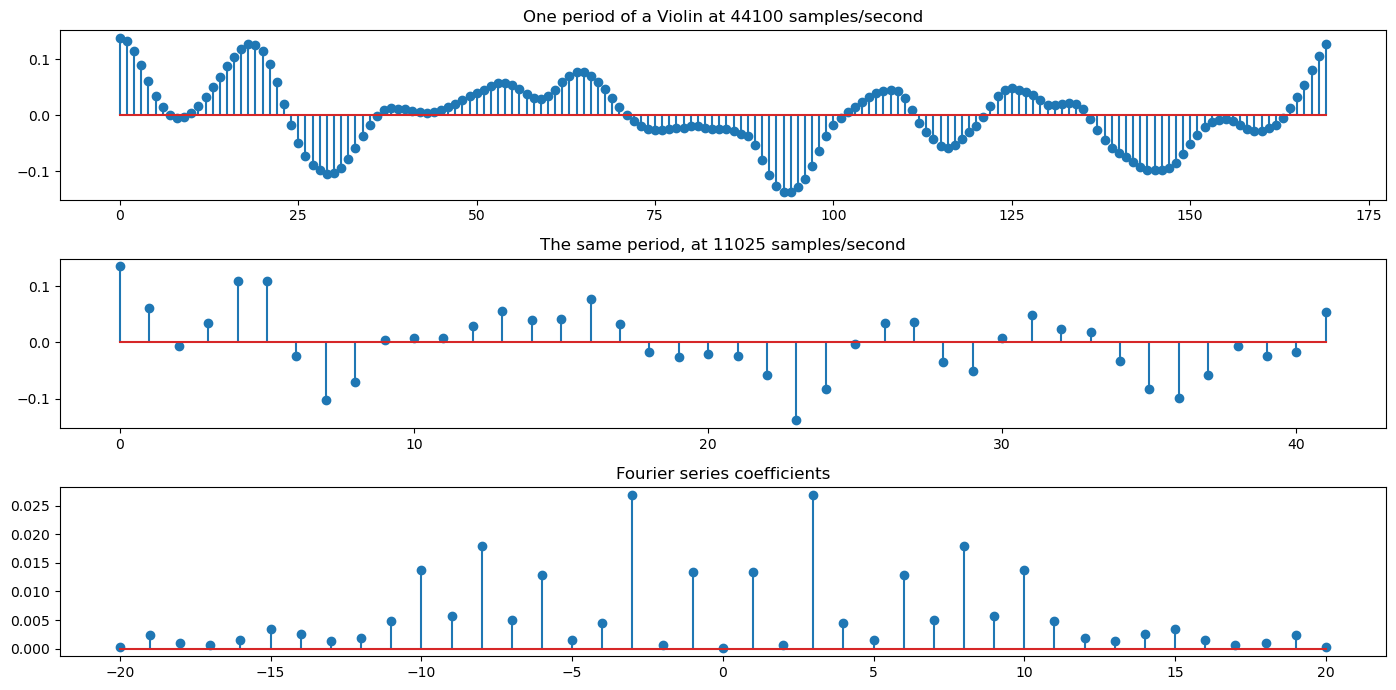

In [58]:
fig, ax = plt.subplots(3,1,figsize=(14,7))
ax[0].stem(highrate_signal)
ax[0].set_title('One period of a Violin at %d samples/second'%(highrate))
ax[1].stem(lowrate_signal)
ax[1].set_title('The same period, at %d samples/second'%(lowrate))
hw = int((len(lowrate_signal)-1)/2)
ax[2].stem(np.arange(-hw,hw+1), np.abs(coefficients))
ax[2].set_title('Fourier series coefficients')
fig.tight_layout()

You can compare your solutions to the reference solutions by opening `extra_solutions.hdf5`, as shown here: 

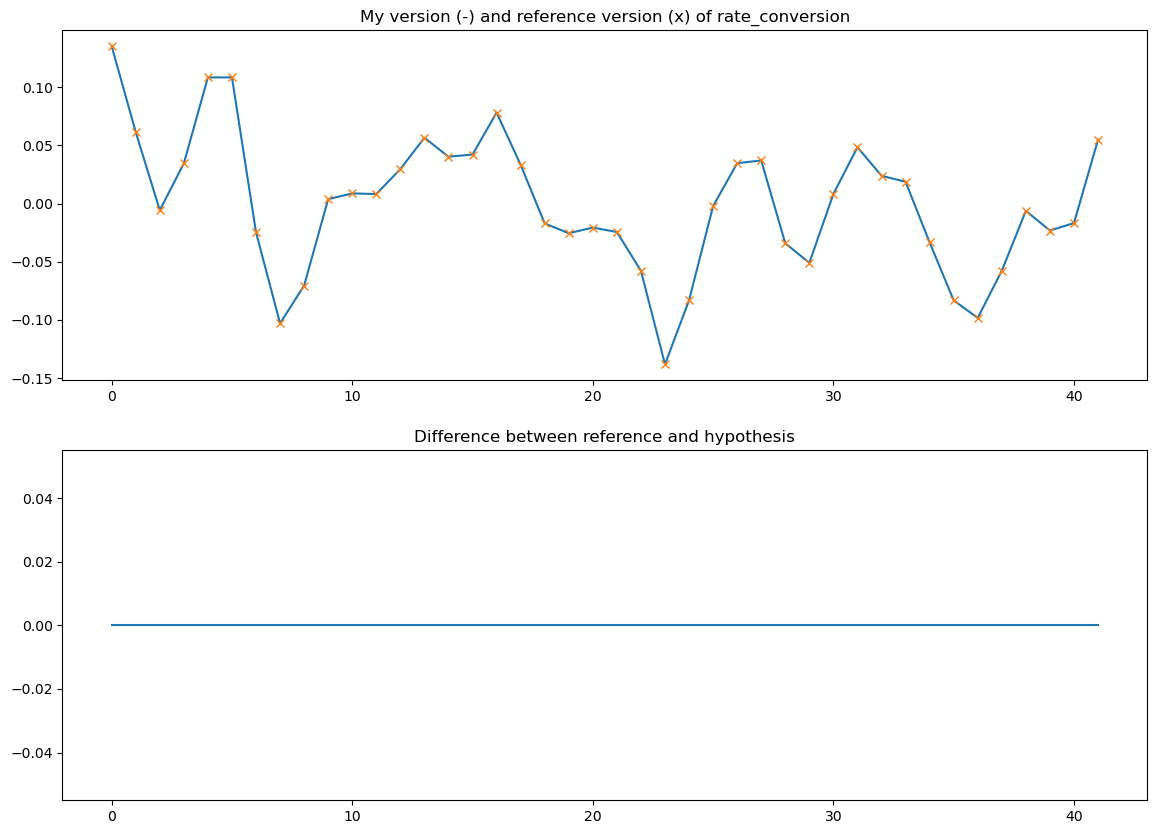

In [60]:
importlib.reload(extra)
with h5py.File('extra_solutions.hdf5','r')  as f:
    lowrate_signal, coefficients = extra.rate_conversion(f['highrate_signal'],f['highrate'][0], f['lowrate'][0])
    fig, ax = plt.subplots(2,1,figsize=(14,10))
    N0 = len(lowrate_signal)
    ax[0].plot(np.arange(N0),lowrate_signal,'-',np.arange(N0),f['lowrate_signal'][:],'x')
    ax[0].set_title('My version (-) and reference version (x) of rate_conversion')
    ax[1].plot(np.arange(N0),lowrate_signal-f['lowrate_signal'])
    ax[1].set_title('Difference between reference and hypothesis')